## This notebook provides the example application of the CNN+FNN aplgorithm developed by 
"Babu,  G. S.,  Zhao,  P.,  Li,  X.-L.,  2016. Deep convolutional neural net-work based regression approach for estimation of remaining useful life.In:  International conference on database systems for advanced applica-tions. Springer, pp. 214–228."

github location of original version: https://github.com/aqibsaeed/Estimation-of-Remaining-Useful-Life-using-CNN

## The only changes made to the original version is the training/testing data split


In [41]:
## all imports
import pandas as pd
import scipy.stats as scy_stats
import numpy as np
from sklearn.preprocessing import scale
#from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing.data import normalize, minmax_scale, StandardScaler,\
    RobustScaler
from IPython.extensions.autoreload import update_class
from matplotlib.pyplot import axis
import itertools
from scipy import stats, integrate
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set(color_codes=True)
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import os
rng = np.random.RandomState(0)
import warnings
warnings.filterwarnings("ignore")
#http://oar.a-star.edu.sg/jspui/bitstream/123456789/1681/3/DASFAA2016_014_final_v1.pdf
#https://arxiv.org/pdf/1612.07640.pdf
#http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6187366

# Methods for split into training and testing sets

In [42]:
def smpl_split(self,d_1):
    '''
    Splitting data  per unit

    '''
    d1_cntr =d_1
    uns_d1 = np.reshape(d1_cntr.unit.unique(), (d1_cntr.unit.unique().shape[0],1))
    if os.path.exists('selc_d1.npy')==1:
        rnd_gen_d1= np.load('selc_d1.npy')
    comb_sep_d1 = pd.DataFrame(uns_d1,columns=['unit'])
    rnd_gen_d1 =rnd_gen_d1[0:uns_d1.shape[0]]
    comb_sep_d1 = comb_sep_d1.assign(indi=rnd_gen_d1)
    slc_tst_d1=comb_sep_d1.iloc[:,0].loc[comb_sep_d1['indi']==1]
    slc_trn_d1=comb_sep_d1.iloc[:,0].loc[comb_sep_d1['indi']!=1]
    psdo_tst_d1= np.empty((0,len(d1_cntr.columns)), np.float)
    psdo_trn_d1= np.empty((0,len(d1_cntr.columns)), np.float)
    for i in slc_tst_d1:
            psdo_tst_d1 = np.append(psdo_tst_d1,d1_cntr.loc[d1_cntr['unit']==i], axis=0)
    psdo_tst_d1 = pd.DataFrame(psdo_tst_d1,columns=d1_cntr.columns) #units used for testing
    for i in slc_trn_d1:    
            psdo_trn_d1 = np.append(psdo_trn_d1,d1_cntr.loc[d1_cntr['unit']==i], axis=0)
    psdo_trn_d1 = pd.DataFrame(psdo_trn_d1,columns=d1_cntr.columns) #units to use for training
    del [i]
    return psdo_tst_d1,psdo_trn_d1

def windows(nrows, size):
    start,step = 0, 2
    while start < nrows:
        yield start, start + size
        start += step
def segment_signal(data,window_size = 15,featsize=2):
    segments = np.empty((0,window_size))
    segment_labels = np.empty((0))
    for i in data.unit.unique():
        data_slc = data.loc[data.unit==i].drop(['unit'],axis=1)
        features = data_slc.drop(['cycle'],axis=1)
        labels = data_slc[['cycle']] * -1
        nrows = len(features)
        for (start, end) in windows(nrows,window_size):
            if(len(features.iloc[start:end]) == window_size):
                segment = features[start:end].T  #Transpose to get segment of size (features x window_size) 
                labels = np.asarray(labels)
                label = labels[(end-1)]
                segments = np.vstack([segments,segment])
                segment_labels = np.append(segment_labels,label)
    segments = segments.reshape(-1,featsize,window_size,1)
    segment_labels = segment_labels.reshape(-1,1)
    return segments,segment_labels

# ML-Framework Methods

In [43]:
def sep_per_OPcond(dset,cond=6):

    OD_d1 = dset
    op_indx = KMeans(n_clusters=cond).fit(OD_d1[[ 'op_set1', 'op_set2', 'op_set3']]).labels_.astype(np.int) #index of condtions
    op_indx = op_indx+1 # avoid 0's
    OD_d1 = OD_d1.drop([ 'op_set1', 'op_set2', 'op_set3'],axis=1)
    OD_d1.insert(2, 'Opcond', op_indx) # machine data with op condition index
    #nom, fail = ExpControl.takeNomFail(self, OD_d1)
    return OD_d1


# Import C-MAPPS jet engines

In [63]:
orig_jets = pd.read_pickle('nrm_jets')# Original data
rduct_jets = pd.read_pickle('RML_jets')# ML-Framework Reduced
rduct_jets['op_set1'] =orig_jets.op_set1
rduct_jets['op_set2'] =orig_jets.op_set2
rduct_jets['op_set3'] =orig_jets.op_set3

rduct_jets['faults'] = rduct_jets['faults'].astype(int)
rduct_jets['Opcond'] = rduct_jets['Opcond'].astype(int)
rduct_jets['unit'] = rduct_jets['unit'].astype(int)
rduct_jets['cycle'] = rduct_jets['cycle'].astype(int)


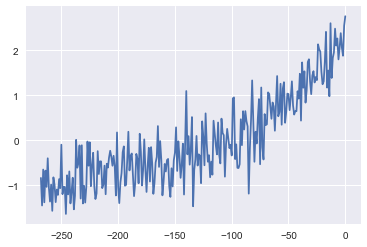

In [47]:
data = rduct_jets.loc[(rduct_jets['unit']==2)]
plt.plot(data.cycle,data.pca1)
plt.show()

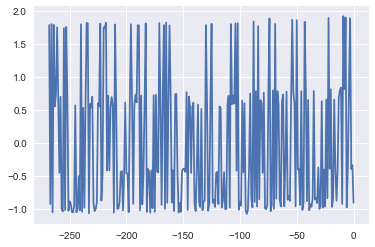

In [48]:
data = orig_jets.loc[(orig_jets['unit']==2)]
plt.plot(data.cycle,data.sm1)
plt.show()

# Split into test and train

In [49]:
# Split data into train and test

# ML-Framework Representation
rJet_tst,rJet_trn = smpl_split('Redct',d_1=rduct_jets)
#Test data
rJet_tst['unit'] = rJet_tst['unit'].astype(int)
rJet_tst['cycle'] = rJet_tst['cycle'].astype(int)
rJet_tst['Opcond'] = rJet_tst['Opcond'].astype(int)
#Train data
rJet_trn['cycle'] = rJet_trn['cycle'].astype(int)
rJet_trn['Opcond'] = rJet_trn['Opcond'].astype(int)
rJet_trn=rJet_trn.drop(['faults'],axis=1)
rJet_trn.head(3)


# Original Data
origJet_tst,origJet_trn = smpl_split('Redct',d_1=orig_jets)
#Test data
origJet_tst['cycle'] = origJet_tst['cycle'].astype(int)
#Train data
origJet_trn['cycle'] = origJet_trn['cycle'].astype(int)


# Create targets and inputs

In [50]:
# Create Targets and inputs
# ML_framework Representation
rJet_trn =rJet_trn.loc[(rJet_trn['cycle']>=-300)][['pca1','pca8','op_set1','op_set2','op_set3','cycle','unit']]
rJet_tst =rJet_tst.loc[(rJet_tst['cycle']>=-300)][['pca1','pca8','op_set1','op_set2','op_set3','cycle','unit']]

train_x, train_y = segment_signal(rJet_trn,window_size = 15,featsize=rJet_trn.drop(['cycle','unit'],axis=1).shape[1])
test_x, test_y = segment_signal(rJet_tst,window_size = 15,featsize=rJet_tst.drop(['cycle','unit'],axis=1).shape[1])

print('train samples :{0}:{1} \n test samples: {2}:{3}'.format(len(train_x),len(train_y),len(test_x),len(test_y)))


# Original Data
origJet_trn = origJet_trn.drop(['faults'],axis=1)
origJet_tst = origJet_tst.drop(['faults'],axis=1)


Origntrain_x, Origntrain_y = segment_signal(origJet_trn,window_size = 15,featsize=origJet_trn.drop(['cycle','unit'],axis=1).shape[1])
Origntest_x, Origntest_y = segment_signal(tst_featsOrign,tst_lblsOrign,window_size = 15,featsize=tst_featsOrign.drop(['cycle','unit'],axis=1).shape[1])

print('train samples :{0}:{1} \n test samples: {2}:{3}'.format(len(Origntrain_x),len(Origntrain_y),len(Origntest_x),len(Origntest_y)))

train samples :17343:17343 
 test samples: 7607:7607


In [51]:
train_x.shape
#train_y.shape

(17343, 5, 15, 1)

# CNN methods

In [52]:

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(1.0, shape = shape)
    return tf.Variable(initial)

def apply_conv(x,kernel_height,kernel_width,num_channels,depth):
    weights = weight_variable([kernel_height, kernel_width, num_channels, depth])
    biases = bias_variable([depth])
    return tf.nn.relu(tf.add(tf.nn.conv2d(x, weights,[1,1,1,1],padding="VALID"),biases))
    
def apply_max_pool(x,kernel_height,kernel_width,stride_size):
    return tf.nn.max_pool(x, ksize=[1, kernel_height, kernel_width, 1], strides=[1, 1, stride_size, 1], padding = "VALID")


# CNN parameters

In [57]:
num_labels = 1
batch_size = 10
num_hidden = 800
learning_rate = 0.0001
training_epochs = 400
input_height = train_x.shape[1] # get from .shape attribute was 24 X_train.shape[1]
input_width = train_x.shape[2] # get from .shape attribute = window size also X_train.shape[2]
num_channels = train_x.shape[3]
total_batches = train_x.shape[0] // batch_size

# CNN Variables

In [54]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_conv(X, kernel_height = 2, kernel_width = 4, num_channels = 1, depth = 8) 
p = apply_max_pool(c,kernel_height = 1, kernel_width = 2, stride_size = 2) 
c = apply_conv(p, kernel_height = 1, kernel_width = 1, num_channels = 8, depth = 14) 
p = apply_max_pool(c,kernel_height = 1, kernel_width = 1, stride_size = 2) 

shape = p.get_shape().as_list()
flat = tf.reshape(p, [-1, shape[1] * shape[2] * shape[3]])

f_weights = weight_variable([shape[1] * shape[2] * shape[3], num_hidden])
f_biases = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(flat, f_weights),f_biases))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.add(tf.matmul(f, out_weights),out_biases)

# Cost function and  Optimization

In [55]:
cost_function = tf.reduce_mean(tf.square(y_- Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)

# CNN Impliment ML-Framework Representation

Training set MSE
4115.836430551115
4095.584901943623
4087.988082445939
2507.52546125804
1544.8635761988098
1475.3059357311631
1434.0915957553761
1410.0078309507799
1390.0833713439881
1369.9214799340225
1349.578441413009
1334.0843530061916
1317.4968193260788
1296.1110454447326
1283.2891569765322
1251.5568011680475
1227.2033011837318
1214.2556954445993
1203.177019295272
1199.926983674613
1191.5922367040773
1182.209791989412
1173.0514094082725
1161.3631177127886
1148.6772250179506
1141.21076722725
1132.7089058985584
1124.7866298997656
1114.6504751676039
1109.4000113211812
1101.2437901905364
1094.8646176603638
1087.7189451342838
1082.325184923404
1076.3541882152617
1069.2795049171377
1065.4487591778475
1057.8830572970685
1052.115638626169
1048.385252975227
1043.0571499247117
1038.1569966619547
1032.1596816836504
1026.8987463757203
1019.8236449202041
1015.9918137889781
1010.9002927215055
1005.8021218347117
1001.1698946131817
997.087051823636
992.1464861364293
988.904376020398
984.7339894675

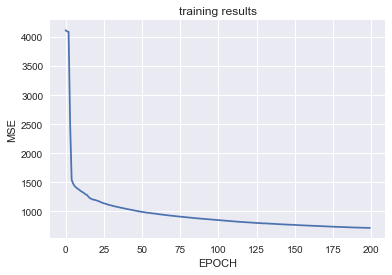

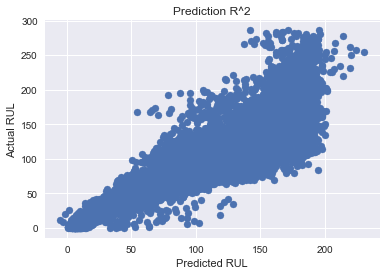

28.98162944554135 20.85550109048358


In [62]:
trained_rms = []
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Training set MSE")
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_x.shape[0] - batch_size) #remained %
            #print(offset)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size),:]
            #print(batch_x.shape)
            #print(batch_y.shape)
            _, c = session.run([optimizer, cost_function],feed_dict={X: batch_x, Y : batch_y})
            
        p_tr = session.run(y_, feed_dict={X:  train_x})
        tr_mse = tf.reduce_mean(tf.square(p_tr - train_y))
        print(session.run(tr_mse))
        trained_rms.append(session.run(tr_mse))

    p_ts = session.run(y_, feed_dict={X:  test_x})
    ts_mse = tf.reduce_mean(tf.square(p_ts - test_y))
    ts_mae = tf.reduce_mean(tf.abs(p_ts-test_y))
    print("Test set MSE: %.4f" % session.run(ts_mse))
    
    plt.plot(np.asarray(range(training_epochs)),trained_rms)
    plt.title('training results')
    plt.ylabel('MSE')
    plt.xlabel('EPOCH')
    plt.show()

    plt.scatter(p_ts,test_y)
    plt.title('Prediction R^2')
    plt.ylabel('Actual RUL')
    plt.xlabel('Predicted RUL')
    plt.show()
    print(math.sqrt(session.run(ts_mse)),session.run(ts_mae))